# モデリング

In [8]:
# 1. ライブラリのインポート
# vscodeで実行する場合にはipykernelパッケージが必要

import pandas as pd
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import matplotlib.pyplot as plt
from pmdarima import arima
from pmdarima import model_selection
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# warningsを無視する
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [9]:
# 2. グラフの設定

plt.style.use('fast') # スタイルの設定
plt.rcParams['figure.figsize'] = [9, 5] # サイズの設定

In [10]:
# 3. DataFrameの作成

file_path = "../data/BloodDonation.csv"
df = pd.read_csv(file_path)

# date 列を作成
df['date'] = pd.to_datetime((df['year'].astype(str)) + '-' + (df['month'].astype(str)))

# date ごとの全国の blood_donors でグループ化
grouped_date_total = df.groupby(['date'])['blood_donors'].sum().to_frame()
grouped_date_total = grouped_date_total.asfreq('MS')  # MS：月初

grouped_date_total.head()

,blood_donors
date,
2017-01-01,406899
2017-02-01,390045
2017-03-01,411315
2017-04-01,390606
2017-05-01,402952


### 時系列分析

外部の説明変数が乏しいため、過去の同じ変数の値を説明変数として扱う時系列分析を行う。
本分析では `blood_donors` という1つの変数を対象にし、過去の献血者数の推移から予測を行うことにする。これは、変数が時間と共に自己回帰的に変化すると仮定するアプローチ。このことからSARIMAモデルを使用する。

### SARIMAモデル

- モデルの選定理由
  - [年ごとの総献血者数の推移](./analyze.ipynb)より献血者数には季節性が見られる
  - トレンドや周期性、突発的な変動を同時にモデル化したい
  - 外部説明変数を持たず、単一の時系列で予測を行いたい

- モデル概要
  
    **SARIMA(p,d,q)(P,D,Q,s)**
    - **p (AR)**: 現在の値が過去の値のどれだけに依存するかを表す **自己回帰**
    - **d (I)**: 時系列データを定常化する回数を表す **和分**
    - **q (MA)**: 過去の誤差が将来の値にどれだけ影響するかを表す **移動平均**

In [11]:
# 学習データとテストデータ（直近12ヶ月間）に分割
train_size = len(grouped_date_total) - 12
df_train = grouped_date_total.iloc[:train_size]

# SARIMAモデルの自動パラメータ探索
smodel = pm.auto_arima(
    df_train,
    start_p=0, start_q=0, max_p=4, max_q=4,
    seasonal=True, m=12, start_P=0, start_Q=0,
    max_P=4, max_Q=4, d=1, D=1, trace=True,
    error_action='ignore', suppress_warnings=True,
    stepwise=True
)

# 選択されたモデルのサマリー
print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1645.037, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1646.584, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1650.512, Time=0.07 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=1645.289, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1644.619, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=1644.791, Time=0.11 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1646.371, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1652.975, Time=0.30 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=1646.623, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,1,1)[12]          
Total fit time: 1.548 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. O

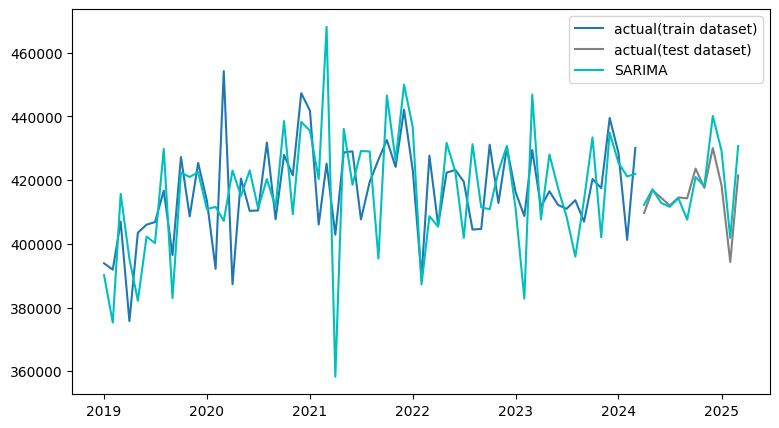

In [12]:
# 学習データとテストデータ（直近12ヶ月間）に分割
df_train, df_test = model_selection.train_test_split(grouped_date_total, test_size=12)

# 原系列を学習データとする
train = df_train

# 学習
sarima_model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 12))
sarima_fit = sarima_model.fit()

# 予測
#学習データの期間の予測値
train_pred = sarima_fit.predict()
#テストデータの期間の予測値
test_pred = sarima_fit.forecast(len(df_test))
#予測区間
test_pred_ci = sarima_fit.get_forecast(len(df_test)).conf_int() 

# グラフ化
fig, ax = plt.subplots()
ax.plot(df_train[24:].index, df_train[24:].values, label="actual(train dataset)")
ax.plot(df_test.index, df_test.values, label="actual(test dataset)", color="gray")
ax.plot(df_train[24:].index, train_pred[24:].values, color="c")
ax.plot(df_test.index, test_pred.values, label="SARIMA", color="c") 
# ax.fill_between(df_test.index, test_pred_ci.iloc[:, 0], test_pred_ci.iloc[:, 1], color='c', alpha=.2)
ax.legend()
plt.show()

### 精度評価

In [13]:
# テストデータで精度検証
print('RMSE: ',np.sqrt(mean_squared_error(df_test, test_pred)))
print('MAE: ',mean_absolute_error(df_test, test_pred)) 
print('MAPE: ',mean_absolute_percentage_error(df_test, test_pred))

print(sarima_fit.summary())

RMSE:  5943.553111004674
MAE:  4397.583333333333
MAPE:  0.010557052626440131
                                     SARIMAX Results                                      
Dep. Variable:                       blood_donors   No. Observations:                   87
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -821.519
Date:                            Fri, 09 May 2025   AIC                           1645.037
Time:                                    02:48:27   BIC                           1647.341
Sample:                                01-01-2017   HQIC                          1645.956
                                     - 03-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.274e+08   2.76e+07     

時系列予測や回帰問題においてモデルの予測性能を評価するための評価関数としてしばしば用いられるRMSE、MAE、およびMAPEを計算します。

- **RMSE (Root Mean Squared Error, 平均二乗平方根誤差)**
  
  一般的に以下の式(1)で定義されます。

    $$
    \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}\qquad(1)
    $$

    誤差の二乗平均の平方根を取ったもので、予測値と実測値の間の差を示します。誤差の大きさに比例する形で影響を与えるため、大きな誤差が強調されます。

- **MAE (Mean Absolute Error, 平均絶対誤差)**

    一般的に以下の式(2)で定義されます。
    
    $$
    \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|\qquad(2)
    $$
    
    誤差の絶対値の平均を取ったもので、予測値と実測値の間の平均的な差を示します。外れ値の影響を受けにくい指標です。

- **MAPE (Mean Absolute Percentage Error, 平均絶対パーセント誤差)**
    
    一般的に以下の式(3)で定義されます。
    
    $$
    \text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{\hat{y}_i - y_i}{y_i} \right|\qquad(3)
    $$
    
    実測値に対する誤差の割合を示します。誤差が実測値に対してどれくらいの割合であるかを示すため、スケールに依存しない指標です。

このとき、

$n$：データ数

${y}_i$：i番目の実測値

$\hat{y}_i$：i番目の予測値

を表します。これらより上記の実行結果は以下のように分析します。

- **RMSE: 5943**
    
    平均的に予測値が実測値から5943人の範囲でずれていることを示します。この値が大きいほどモデルの精度が低いことを示します。
    
- **MAE: 4397**
    
    平均的に予測値が実測値から4397人の範囲でずれていることを示します。これは誤差の大きさを直接示しており、RMSEと比較すると外れ値の影響を受けにくいです。
    
- **MAPE: 0.0105 (約1.05%)**
    
    平均的に予測値が実測値から1.0%の範囲でずれていることを示します。MAPEが低いほど予測精度が高いことを示します。

### 考察

グラフを見ると大きく予測を外しているのにMAPEが1%であることに驚きました。しかし、実測値が毎月40万人前後あることを考えると、4400人の誤差は全体の数%に過ぎないと考えるべきでしょうか。そこで、式(2)、式(3)を用いて平均実測値$\bar{y}$を求めることにしました。

(2)より

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|=4400\qquad(2)'
$$

(3)より

$$
\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left| \frac{\hat{y}_i - y_i}{y_i} \right|=0.01\qquad(3)'
$$

(2)’を(3)’に代入

$$
\frac{4400}{\bar{y}}=0.01
$$
$$
\bar{y}=\frac{4400}{0.01}=440000
$$

したがって平均実測値$\bar{y}$＝44万人と導くことができました。

実測値のスケールが非常に大きいため、PMSE、MAEが大きくても、割合としては小さいことが確認できました。また、MAEがRMSEよりも小さい値を示しているため、外れ値の影響がある程度抑えられていることがわかります。

今回のSARIMAモデルは、MAPEが2%であることからデータに対して比較的高い予測精度を示していると結論付けます。


### 参考にしたサイト等
https://momonoki2017.blogspot.com/2018/03/python9sarima.html<br>
https://www.salesanalytics.co.jp/datascience/datascience087/#pdq_PDQm<br>
https://qiita.com/KENTAROSZK/items/a8d25122a9659967d9f4<br>
https://blog.since2020.jp/data_analysis/arima%E3%83%A2%E3%83%87%E3%83%AB%E3%81%A7%E6%99%82%E7%B3%BB%E5%88%97%E4%BA%88%E6%B8%AC%E3%82%92%E3%82%84%E3%81%A3%E3%81%A6%E3%81%BF%E3%82%8B/<br>
